## Generate Particles

Run a particle-mesh simulation to get a sample of dark-matter particles.

- This relies on the package `pmwd` (Yin Li et al. https://github.com/eelregit/pmwd). You have to install it for this example.
- Instead, you can read particles from arbitrary sources and finish the rest of the notebook.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['JAX_PLATFORMS'] = 'cpu'
import jax

import numpy as np
from pmwd import (
    Configuration,
    Cosmology, SimpleLCDM,
    boltzmann, linear_power, growth,
    white_noise, linear_modes,
    lpt,
    nbody,
    scatter,
)
from pmwd.pm_util import fftinv
from pmwd.spec_util import powspec
from pmwd.vis_util import simshow

In [2]:
def example_particles(l_box=500.0, n_ptcls=128, seed=10086, verbose=False) -> np.ndarray:
    '''
    An example modified from the demon of pmwd (Yin Li et al).
    '''
    ptcl_spacing = l_box / n_ptcls
    ptcl_grid_shape = (n_ptcls,) * 3
    mesh_shape = 2
    
    conf = Configuration(ptcl_spacing, ptcl_grid_shape,
                         mesh_shape=mesh_shape)  # 2x mesh shape
    if verbose:
        print(conf)  # with other default parameters
        print(
            f'Simulating {conf.ptcl_num} particles with a '
            f'{conf.mesh_shape} mesh for {conf.a_nbody_num} time steps.')

    cosmo = SimpleLCDM(conf)
    cosmo = boltzmann(cosmo, conf)
    if verbose:
        print('Cosmology=', cosmo)

    modes = white_noise(seed, conf)
    modes = linear_modes(modes, cosmo, conf, None, False)
    
    ptcl, obsvbl = lpt(modes, cosmo, conf)
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    disp = np.asarray(ptcl.disp)
    pmid = np.asarray(ptcl.pmid)
    
    l_grid = ptcl_spacing / mesh_shape
    x = pmid * l_grid + disp
    
    return x

In [3]:
l_box = 500.0
n_ptcls = 128
pos = example_particles(l_box=l_box, n_ptcls=n_ptcls)
pos

array([[-3.799e-01,  6.417e-01, -1.087e+00],
       [-4.596e+00, -5.674e-01,  6.417e+00],
       ...,
       [ 4.914e+02,  4.976e+02,  4.946e+02],
       [ 4.911e+02,  4.971e+02,  4.965e+02]])

## Classify the cosmic web to knots, filaments, sheets, and voids

In [12]:
import matplotlib.pyplot as plt
from cosmic_web_classifier import Field, Mesh, DensityField, TidalField, TidalClassifier, classifiler_from_particles

First, compute the density field on a mesh of shape (256, 256, 256).

In [13]:
n_grids = 256
df = DensityField(l_box=l_box, n_grids=n_grids)
df.add(pos)

# get density field (i.e. mass assigned to each grid point) via `data` member
rho = df.data
rho.shape

(256, 256, 256)

Make a plot of the density contrast field in logaritmic scale.

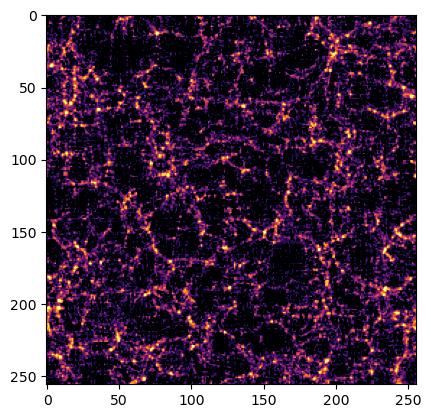

In [14]:
rho_contrast = rho / rho.mean()
img = np.log10(rho_contrast[:, :, :16].max(-1) + 1.0e-10) 
plt.imshow(img, cmap='inferno', vmin=0.5, vmax=2.)

Compute the eigenvalues of tidal tensor
- The smoothing scale, `r_sm` should be chosen appropriately according to your specific task.

In [15]:
mesh = Mesh.new(n_grids, l_box)
field = Field.new_by_data(rho, mesh)

tf = TidalField(r_sm = 2.5)
res = tf.run(field)
res.lam.shape

(256, 256, 256, 3)

Use the eigenvalues to get the classifier.
- The threshold, `lam_th`, has to be chosen appropriately according to your specific task.

In [24]:
clsf = TidalClassifier(res.lam, mesh, lam_th=0.2)
clsf

{ 'type': 'TidalClassifier',
  'mesh': {'type': 'Mesh', 'n_grids': 256, 'l_box': 500.0, 'l_grid': 1.953125},
  'lam_th': 0.2,
  'web_types': { 'knot': 3,
                 'filament': 2,
                 'sheet': 1,
                 'void': 0,
                 'k': 3,
                 'f': 2,
                 's': 1,
                 'v': 0},
  'f_knot': 0.014426052570343018,
  'f_filament': 0.19177037477493286,
  'f_sheet': 0.43780672550201416,
  'f_void': 0.35599684715270996}

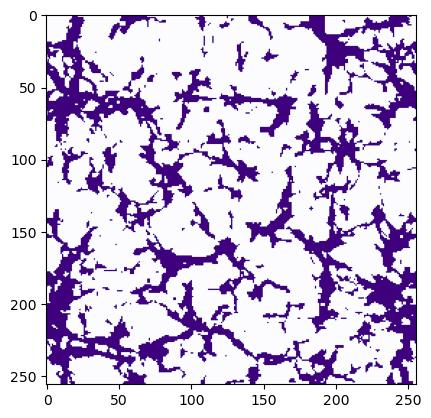

In [17]:
# see whether a grid point is in a filament for a slice of the field
is_fil = clsf.is_void[:, :, :16].any(-1)
plt.imshow(is_fil, cmap='Purples_r', vmin=0, vmax=1.)

You can check the type of the cosmic web at any location within the periodic box.

In [18]:
positions = np.array([
    [10.0, 10.0, 10.0],
    [10.0, 10.0, 40.0],
])
web_types = clsf.web_type_at(positions)
web_types

array([0, 2])

In [19]:
web_types == clsf.web_types['filament']

array([False,  True])

The steps of getting the classifier from particles is fused into a single shortcut function `classifier_from_particles`:

In [25]:
clsf = classifiler_from_particles(l_box=500.0, n_grids=256, positions=pos, r_sm=2.5, lam_th=0.2)
clsf

{ 'type': 'TidalClassifier',
  'mesh': {'type': 'Mesh', 'n_grids': 256, 'l_box': 500.0, 'l_grid': 1.953125},
  'lam_th': 0.2,
  'web_types': { 'knot': 3,
                 'filament': 2,
                 'sheet': 1,
                 'void': 0,
                 'k': 3,
                 'f': 2,
                 's': 1,
                 'v': 0},
  'f_knot': 0.014426052570343018,
  'f_filament': 0.19177037477493286,
  'f_sheet': 0.43780672550201416,
  'f_void': 0.35599684715270996}